In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import re
import subprocess
import datetime
from planar_ising_models import PlanarIsingModelGenerator, IsingInferenceAndSampling, nested_dissection, \
        expanded_dual_graph_constructor

np.random.seed(42)

In [2]:
def compute_log_partition_function_kac_ward(ising_model):

    embedding_points = get_embedding_points(ising_model.graph)
    interactions_matrix = get_interactions_matrix(ising_model)

    spins_count = ising_model.graph.size

    kac_ward_matrix = get_kac_ward_matrix(embedding_points, interactions_matrix)

    _, kac_ward_det_log = np.linalg.slogdet(kac_ward_matrix)

    pairwise_interaction_coshs = np.cosh(interactions_matrix[np.triu_indices(spins_count)])

    return np.log(2)*spins_count + kac_ward_det_log/2 + np.log(pairwise_interaction_coshs).sum()

def get_embedding_points(graph):

    edge_list_filename = 'edgelist.tmp'
    embedding_filename = 'embedding.tmp'
    embedding_command = './straightline {}'.format(edge_list_filename)

    edge_list_lines = []

    for vertex in range(graph.size):
        for adjacent_vertex in graph.get_adjacent_vertices(vertex):
            if vertex < adjacent_vertex:
                edge_list_lines.append('{0}, {1}'.format(vertex, adjacent_vertex))

    with open(edge_list_filename, 'w') as edge_list_file:
        edge_list_file.write('\n'.join(edge_list_lines))

    with open(embedding_filename, 'w') as embedding_file:
        subprocess.run(embedding_command.split(), stdout=embedding_file)

    pattern = re.compile(r'^\d+\[pos\=\"(\d+)\,(\d+)\!\"\]\;')

    embedding_points = []

    with open(embedding_filename, 'r') as embedding_file:
        for line in embedding_file:

            match = pattern.match(line)

            if match is None:
                continue

            embedding_points.append([float(match[1]), float(match[2])])

            if len(embedding_points) == graph.size:
                break

    return np.asarray(embedding_points)

def get_interactions_matrix(ising_model):

    graph = ising_model.graph
    interaction_values = ising_model.interaction_values

    interactions_matrix = np.zeros((graph.size, graph.size), dtype=np.float64)

    interactions_matrix[graph.edges.vertex1, graph.edges.vertex2] = interaction_values
    interactions_matrix[graph.edges.vertex2, graph.edges.vertex1] = interaction_values

    return interactions_matrix

def get_kac_ward_matrix(embedding_points, interactions_matrix):

    spins_count = len(embedding_points)

    directed_edge_indices = {edge:i for i, edge in enumerate(zip(*np.where(interactions_matrix != 0)))}
    directed_edges_count = len(directed_edge_indices)

    kac_ward_matrix = np.zeros((directed_edges_count, directed_edges_count),
                               dtype=np.complex128)

    for spin_index1 in range(spins_count):

        for spin_index2 in range(spins_count):

            if interactions_matrix[spin_index1, spin_index2] == 0:
                continue

            directed_edge_index1 = directed_edge_indices[(spin_index1, spin_index2)]

            kac_ward_matrix[directed_edge_index1, directed_edge_index1] = 1

            for spin_index3 in range(spins_count):

                if interactions_matrix[spin_index2, spin_index3] == 0:
                    continue

                if spin_index1 == spin_index3:
                    continue

                point1 = embedding_points[spin_index1]
                point2 = embedding_points[spin_index2]
                point3 = embedding_points[spin_index3]

                half_rotation_number = get_half_rotation_complex_number(point1, point2, point3)

                directed_edge_index2 = directed_edge_indices[(spin_index2, spin_index3)]

                kac_ward_matrix[directed_edge_index1, directed_edge_index2] = -half_rotation_number*\
                        np.tanh(interactions_matrix[spin_index2, spin_index3])

    return kac_ward_matrix

def get_half_rotation_complex_number(point1, point2, point3):

    vector1 = point2 - point1
    vector2 = point3 - point2

    dot_product = (vector1*vector2).sum()
    cross_product_z = vector1[0]*vector2[1] - vector1[1]*vector2[0]

    angle_cos = dot_product/(np.linalg.norm(vector1)*np.linalg.norm(vector2))
    half_angle_cos = np.sqrt((1 + angle_cos)/2)
    half_angle_sin = -np.sign(cross_product_z)*np.sqrt((1 - angle_cos)/2)

    return half_angle_cos + 1j*half_angle_sin

In [3]:
graph_density = 0.8
interaction_values_std = 0.1

In [4]:
def draw_kac_ward_relative_error():

    graph_sizes = np.arange(5, 105, 5)
    samples_count = 20

    graph_sizes_per_sample = []
    relative_errors_per_sample = []

    for graph_size in graph_sizes:
    
        for sample_index in range(samples_count):

            graph_sizes_per_sample.append(graph_size)

            ising_model = PlanarIsingModelGenerator.generate_random_model(graph_size, graph_density,
                    interaction_values_std)

            kac_ward_log_partition_function = compute_log_partition_function_kac_ward(ising_model)

            ising_inference = IsingInferenceAndSampling(ising_model)
            log_partition_function = ising_inference.compute_log_partition_function()

            relative_error = np.absolute((kac_ward_log_partition_function - \
                    float(log_partition_function))/kac_ward_log_partition_function)

            relative_errors_per_sample.append(relative_error)

    plt.scatter(graph_sizes_per_sample, np.log10(relative_errors_per_sample), s=10, c='k')
    plt.title('Relative error with Kac-Ward')
    plt.ylabel('$\log_{10} (error)$')
    plt.xlabel('size')

    plt.show()

def draw_execution_time():

    log2_graph_sizes = np.arange(2, 15)
    samples_count = 1

    log2_graph_sizes_per_sample = []
    execution_times_per_samples = []

    for log2_graph_size in log2_graph_sizes:

        graph_size = 2**log2_graph_size

        for sample_index in range(samples_count):

            log2_graph_sizes_per_sample.append(log2_graph_size)

            ising_model = PlanarIsingModelGenerator.generate_random_model(graph_size, graph_density,
                    interaction_values_std)

            start_moment = datetime.datetime.now()

            ising_inference = IsingInferenceAndSampling(ising_model)
            ising_inference.compute_log_partition_function()

            execution_time = (datetime.datetime.now() - start_moment).total_seconds()

            execution_times_per_samples.append(execution_time)

        print('Done with size {}'.format(graph_size))

    plt.figure(figsize=(9, 6))

    plt.scatter(log2_graph_sizes_per_sample, np.log2(execution_times_per_samples), c='k', s=8,
            label='experimental')

    plt.plot(log2_graph_sizes, 3*log2_graph_sizes - 10, '--', label='$O(size^3)$')
    plt.plot(log2_graph_sizes, 1.5*log2_graph_sizes - 10, '--', label='$O(size^{1.5})$')

    plt.title('Run time')
    plt.xlabel('$\log_2 (size)$')
    plt.ylabel('$\log_2 (sec.)$')
    plt.legend()
    plt.show()

/home/valera/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in sqrt
/home/valera/anaconda3/lib/python3.6/site-packages/numpy/linalg/linalg.py:1741: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/home/valera/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars
/home/valera/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log10


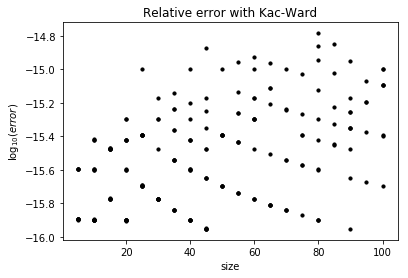

In [5]:
draw_kac_ward_relative_error()

Done with size 4
Done with size 8
Done with size 16
Done with size 32
Done with size 64
Done with size 128
Done with size 256
Done with size 512
Done with size 1024
Done with size 2048
Done with size 4096
Done with size 8192
Done with size 16384
Done with size 32768


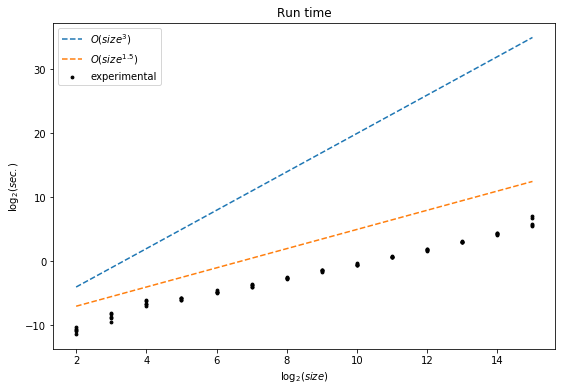

In [6]:
draw_execution_time()